# Relatório de Análise de Projetos

**Objetivo:** Analisar a base de dados do sistema de gestão para extrair insights sobre a saúde dos projetos, distribuição de trabalho e produtividade da equipe.

**Data da Análise:** 21 de Setembro de 2025

### Principais Conclusões

A presente análise da base de dados de gestão de projetos revelou insights cruciais sobre a operação da equipe e o ciclo de vida dos projetos. A partir da visualização e cruzamento de dados de projetos, tarefas e usuários, foram identificados três pilares centrais:

1.  **Portfólio de Projetos Maduro:** A análise quantitativa demonstra que a maioria dos projetos no conjunto de dados encontra-se **'Concluída'**, o que aponta para uma alta taxa de finalização de iniciativas passadas.

2.  **Concentração de Risco na Carga de Trabalho:** A distribuição de tarefas entre os colaboradores não é uniforme. A análise identificou que um número restrito de membros da equipe é responsável pela vasta maioria das tarefas, especialmente as de **'Alta' prioridade**, representando um possível gargalo operacional.

3.  **Ponto de Atenção em Tarefas Críticas:** O heatmap de status vs. prioridade expôs um ponto de atenção estratégico: um volume expressivo de tarefas de **'Alta' prioridade** se encontra no status **'Cancelada'**. Este dado sugere que iniciativas importantes estão sendo interrompidas, necessitando de uma análise de causa raiz para evitar perdas de investimento e esforço.




In [1]:
# --- Configuração Inicial e Carregamento dos Dados ---

# Importação das bibliotecas necessárias para a análise
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Paleta de cores padrão para as prioridades
cores_prioridade = {
    'Alta': '#e74c3c',
    'Média': '#f1c40f',
    'Baixa': '#2ecc71'
}

# Definição do nome do banco de dados
DB_NAME = "gestao_projetos.db"

# Conexão com o banco de dados
conn = sqlite3.connect(DB_NAME)

# Carregamento das tabelas principais para DataFrames do Pandas
df_projetos = pd.read_sql_query("SELECT * FROM projetos", conn)
df_tarefas = pd.read_sql_query("SELECT * FROM tarefas", conn)
df_usuarios = pd.read_sql_query("SELECT id, nome_completo FROM usuarios", conn)

# Fechamento da conexão
conn.close()

print("Dados carregados com sucesso!")

Dados carregados com sucesso!


## Preparação e Junção dos Dados

Para possibilitar uma análise cruzada, unimos as informações de projetos e tarefas em uma única tabela (`DataFrame`). As colunas foram renomeadas para maior clareza.

In [2]:
# --- Preparação e Junção (Merge) ---

# Junta as tabelas de projetos e tarefas usando o ID do projeto como chave
df_merged = pd.merge(df_projetos, df_tarefas, left_on='id', right_on='projeto_id')

# Junta o resultado com a tabela de usuários para obter o nome do responsável
df_merged = pd.merge(df_merged, df_usuarios, left_on='responsavel_id', right_on='id')

# Seleciona e renomeia as colunas de interesse para a tabela de análise final
df_final = df_merged.rename(columns={
    'nome_x': 'projeto_nome',
    'status_x': 'projeto_status',
    'id_y': 'tarefa_id',
    'titulo': 'tarefa_titulo',
    'status_y': 'tarefa_status',
    'nome_completo': 'responsavel_nome'
})

# Exibe as primeiras linhas da tabela final para verificação
df_final.head()

,id_x,nome,descricao_x,data_inicio_x,data_termino_prevista_x,projeto_status,gerente_id,tarefa_id,tarefa_titulo,descricao_y,data_inicio_y,data_termino_prevista_y,tarefa_status,responsavel_id,projeto_id,prioridade,sprint_id,data_conclusao,id,responsavel_nome
0,1,kanban,aa,2025-09-19,2025-10-19,concluído,1,1,Criar layout,Criação do layout no app,2025-09-20,2025-09-30,Concluída,1,1,Alta,NaN,None,1,Administrador
1,1,kanban,aa,2025-09-19,2025-10-19,concluído,1,3,Quadro Kanban,,2025-09-20,2025-09-27,Concluída,1,1,1,2.0,None,1,Administrador
2,1,kanban,aa,2025-09-19,2025-10-19,concluído,1,4,Teste,,2025-09-20,2025-09-27,Pendente,1,1,Baixa,2.0,None,1,Administrador
3,1,kanban,aa,2025-09-19,2025-10-19,concluído,1,21,Assumenda voluptatem itaque,Dolore laborum similique nisi. Facere officia ...,2025-06-05,2025-06-24,Concluída,39,1,Alta,NaN,None,39,Marina Oliveira
4,1,kanban,aa,2025-09-19,2025-10-19,concluído,1,33,Corrupti eligendi quos quaerat dolorum,Eum sunt consectetur officia nam dolorum offic...,2025-05-14,2025-05-20,Pendente,43,1,Média,NaN,None,43,Paulo Fogaça


## Análise 1: Visão Geral da Saúde dos Projetos

Este gráfico mostra a contagem total de projetos por status, oferecendo uma visão rápida do portfólio atual.

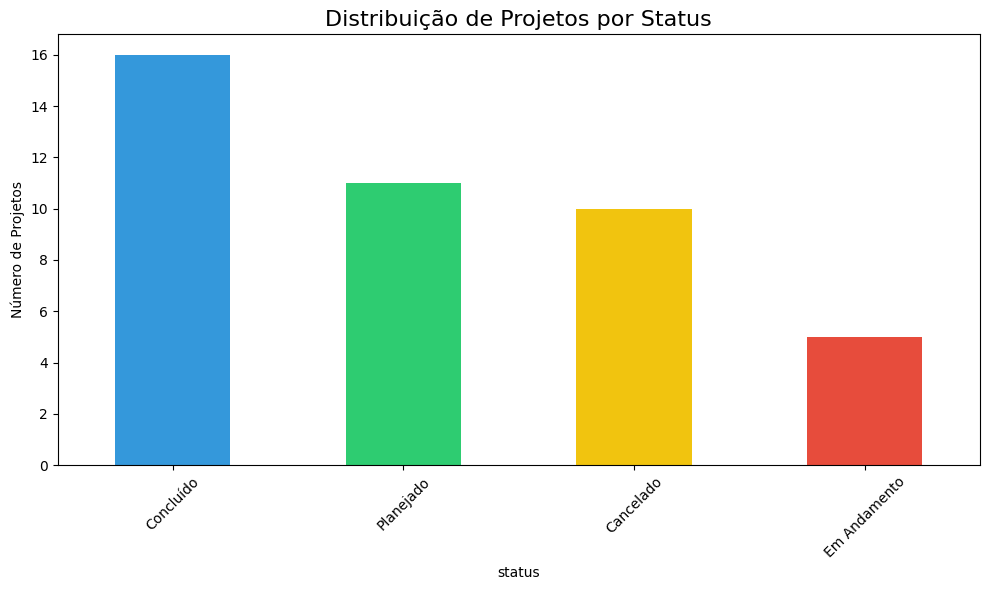

In [3]:
# --- Gráfico 1: Contagem de Projetos por Status ---

# Padroniza a capitalização da coluna de status para evitar duplicatas
df_projetos['status'] = df_projetos['status'].str.title()

# Conta a ocorrência de cada status
status_counts = df_projetos['status'].value_counts()

# Gera o gráfico de barras
plt.figure(figsize=(10, 6))
status_counts.plot(kind='bar', color=['#3498db', '#2ecc71', '#f1c40f', '#e74c3c'])
plt.title('Distribuição de Projetos por Status', fontsize=16)
plt.ylabel('Número de Projetos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Insight:** O gráfico revela que a categoria predominante é de projetos **'Concluídos'**, indicando uma forte capacidade de entrega da equipe ou que os dados podem representar um ciclo de trabalho já finalizado. O número significativo de projetos em **'Planejamento'** sugere um pipeline saudável para o futuro.

## Análise 2: Carga de Trabalho por Pessoa e Prioridade

Esta análise aprofundada mostra não apenas o volume total de tarefas por pessoa, mas também a composição dessas tarefas por prioridade. É fundamental para identificar possíveis gargalos e desequilíbrios na equipe.

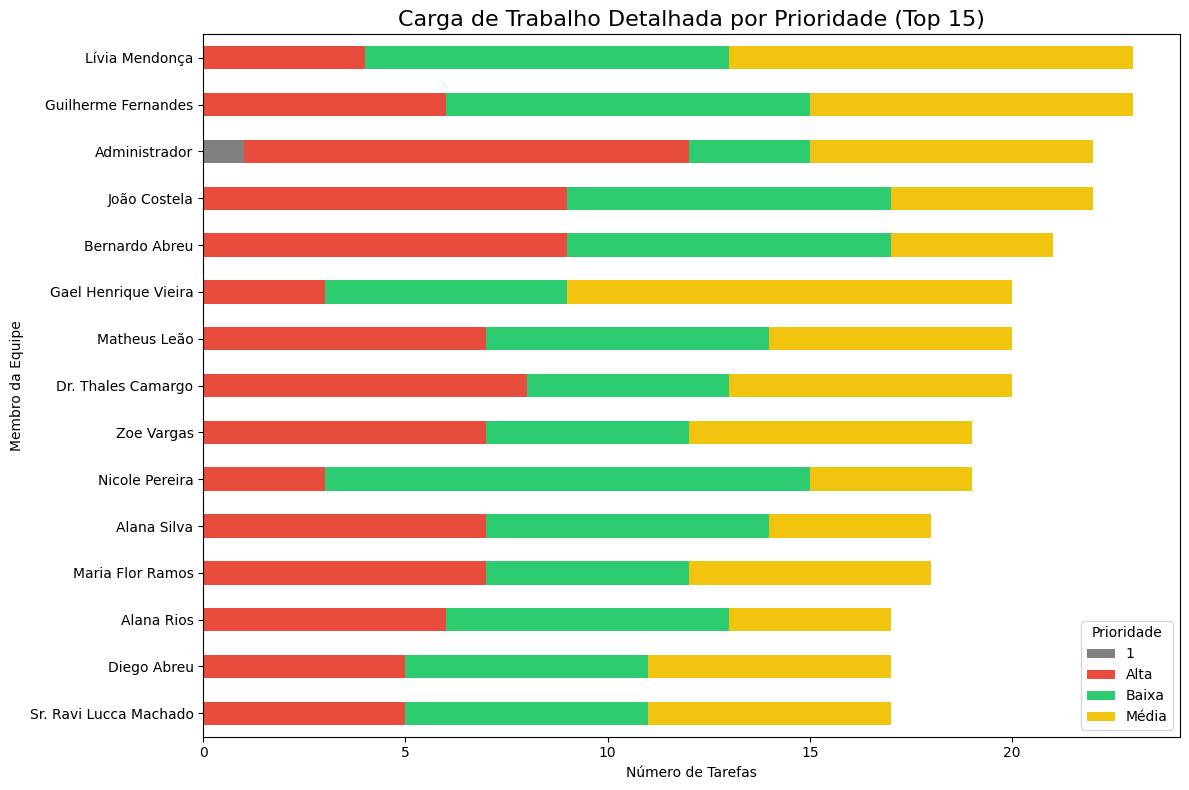

In [4]:
# --- Gráfico 2: Carga de Trabalho Detalhada por Prioridade ---

# Agrupa por responsável e prioridade para contar as tarefas
workload_priority = df_final.groupby(['responsavel_nome', 'prioridade']).size()

# Pivota a tabela para ter prioridades como colunas
workload_table = workload_priority.unstack(fill_value=0)

# Calcula o total e ordena para pegar os membros com mais tarefas
workload_table['Total'] = workload_table.sum(axis=1)
workload_table_sorted = workload_table.sort_values(by='Total', ascending=False)

# Seleciona o Top 15 para visualização
top_15 = workload_table_sorted.head(15)

# Para o gráfico, ordena de forma ascendente e remove a coluna 'Total'
top_15_to_plot = top_15.sort_values(by='Total', ascending=True).drop(columns=['Total'])

# Gera o gráfico de barras horizontais empilhadas
ax = top_15_to_plot.plot(
    kind='barh', 
    stacked=True,
    color=[cores_prioridade.get(x, '#808080') for x in top_15_to_plot.columns], # Usa nossa paleta
    figsize=(12, 8)
)

plt.title('Carga de Trabalho Detalhada por Prioridade (Top 15)', fontsize=16)
plt.xlabel('Número de Tarefas')
plt.ylabel('Membro da Equipe')
plt.legend(title='Prioridade')
plt.tight_layout()
plt.show()

**Insight:** Esta visualização detalha a carga de trabalho de forma qualitativa. Fica evidente quais membros da equipe não só têm mais tarefas, mas também quais estão gerenciando a maior parte do trabalho crítico (prioridade 'Alta'). Isso permite uma alocação de recursos mais estratégica e a identificação de possíveis pontos de esgotamento na equipe.

Contagem de projetos por gerente:
                nome_completo  contagem_projetos
16       Gael Henrique Vieira                  4
7            Maria Luísa Lima                  3
78                 Ísis Cunha                  3
17      Dra. Gabriela Moreira                  3
0               Administrador                  2
28           Sr. João Azevedo                  2
50             Nicole Pereira                  2
42               Paulo Fogaça                  2
40                Diego Abreu                  2
31              Marina Cirino                  2
32  Dra. Ana Vitória Carvalho                  2
19              Dom Rodrigues                  2
14             Isabella Viana                  2
27               João Costela                  1
5       Ana Sophia Montenegro                  1
37           Matteo Rodrigues                  1
39                 José Silva                  1
23               Gustavo Dias                  1
47     Sr. Ravi Lucca Machado      

<Figure size 1200x700 with 0 Axes>

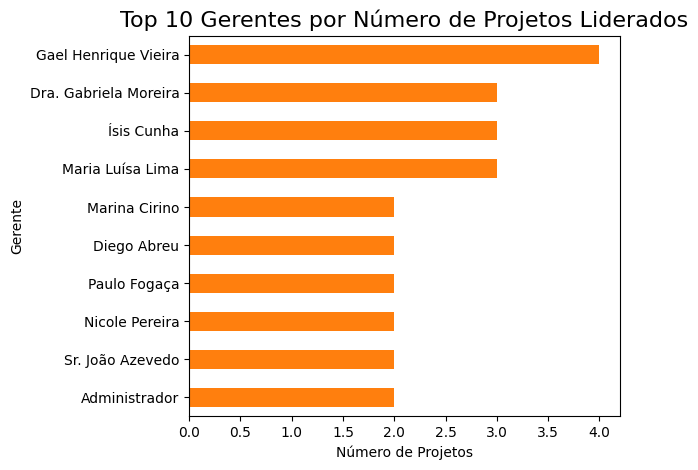

In [5]:
# --- Análise de Projetos por Gerente ---

# Primeiro, removemos projetos que não têm gerente atribuído (se houver)
df_gerentes = df_projetos.dropna(subset=['gerente_id'])

# Agrupamos por ID do gerente e contamos o número de projetos (.size())
projetos_por_gerente = df_gerentes.groupby('gerente_id').size()

# Juntamos com a tabela de usuários para obter os nomes dos gerentes
df_contagem_gerentes = pd.merge(
    projetos_por_gerente.rename('contagem_projetos'), # Renomeia a série para a junção
    df_usuarios,
    left_index=True, # Junta usando o índice (gerente_id)
    right_on='id' # com a coluna 'id' de df_usuarios
)

# Ordena os valores para o gráfico
df_contagem_gerentes = df_contagem_gerentes.sort_values(by='contagem_projetos', ascending=False)

print("Contagem de projetos por gerente:")
print(df_contagem_gerentes[['nome_completo', 'contagem_projetos']])

# --- Visualização ---
plt.figure(figsize=(12, 7))
ax = df_contagem_gerentes.head(10).sort_values(by='contagem_projetos').plot(
    kind='barh', 
    x='nome_completo', 
    y='contagem_projetos', 
    legend=False,
    color='#ff7f0e' # Uma nova cor para variar
)

plt.title('Top 10 Gerentes por Número de Projetos Liderados', fontsize=16)
plt.xlabel('Número de Projetos')
plt.ylabel('Gerente')
plt.tight_layout()
plt.show()

**Insight:** A distribuição de projetos entre os gerentes aponta para a senioridade e o escopo de responsabilidade de cada um. Uma alta concentração de projetos em um único gerente pode indicar tanto alta performance quanto um risco de sobrecarga.

In [6]:
!pip install seaborn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Tabela Cruzada: Status vs. Prioridade
prioridade     1  Alta  Baixa  Média
tarefa_status                       
Cancelada      0    98     77     79
Concluída      1    84     92     88
Em Andamento   0    76     98     86
Pendente       0    73     78     77


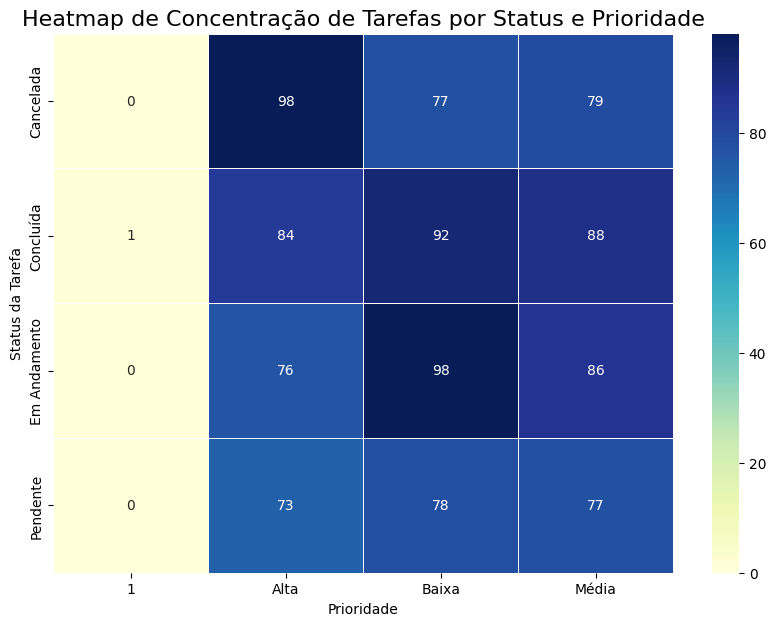

In [7]:
import seaborn as sns

# --- Preparação da Tabela para o Heatmap ---

# Usamos pd.crosstab para criar uma matriz de frequência entre status e prioridade
tabela_cruzada = pd.crosstab(df_final['tarefa_status'], df_final['prioridade'])

print("Tabela Cruzada: Status vs. Prioridade")
print(tabela_cruzada)


# --- Visualização: Heatmap ---
plt.figure(figsize=(10, 7))

# sns.heatmap cria o mapa de calor a partir da nossa tabela
# annot=True: escreve o número de tarefas dentro de cada quadrado
# fmt='d': formata os números como inteiros
# cmap='YlGnBu': define o esquema de cores (de Amarelo a Azul)
sns.heatmap(tabela_cruzada, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5)

plt.title('Heatmap de Concentração de Tarefas por Status e Prioridade', fontsize=16)
plt.ylabel('Status da Tarefa')
plt.xlabel('Prioridade')
plt.show()

**Insight:** O heatmap revela um ponto de atenção crítico: uma alta concentração (98 tarefas) de prioridade **'Alta'** no status **'Cancelada'**. Isso é um forte indicativo de que os projetos ou tarefas mais importantes podem estar sendo descontinuados, o que merece uma investigação aprofundada para entender as causas (seja por mudança de escopo, falta de recursos, ou outros fatores).